In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import datetime as dt
import plotly
from sklearn import linear_model 
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout
from subprocess import check_output

print(check_output(["ls", "/root/userspace/final/input"]).decode("utf8"))
import os
os.chdir('/root/userspace/final/input')

#Load the Data 
filename = '4307.jp.txt'
data = pd.read_csv(filename, sep=',')
label, _, _ = filename.split(sep='.')
data['Label'] = filename
data['Date'] = pd.to_datetime(data['Date'])
print(data)

4307.jp.txt

           Date   Open   High    Low  Close   Volume  CloseAdjust        Label
0    2001-12-17  14850  14850  13800  14050  6566899        774.1  4307.jp.txt
1    2001-12-18  14000  14080  13810  13900  1358100        765.8  4307.jp.txt
2    2001-12-19  13890  14100  13420  13960   921800        769.2  4307.jp.txt
3    2001-12-20  14100  14290  13930  14230   533800        784.0  4307.jp.txt
4    2001-12-21  14300  14580  14100  14550   508000        801.7  4307.jp.txt
5    2001-12-25  14550  14550  14060  14100   140700        776.9  4307.jp.txt
6    2001-12-26  14300  14940  14200  14890   416300        820.4  4307.jp.txt
7    2001-12-27  15090  15490  15060  15320   835900        844.1  4307.jp.txt
8    2001-12-28  15500  15520  15310  15380   229200        847.4  4307.jp.txt
9    2002-01-04  15580  15620  15100  15310   168800        843.5  4307.jp.txt
10   2002-01-07  15490  16130  15390  15900   585500        876.0  4307.jp.txt
11   2002-01-08  15990  16540  15910  1

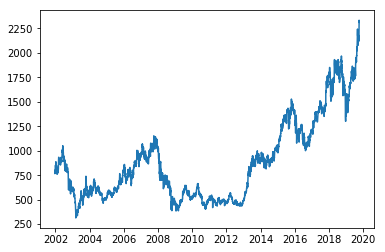

In [16]:
#Close Price adjusted
data = data.sort_values('Date')
label = data['Label'].iloc[0]
plt.plot(data['Date'], data['CloseAdjust'], label="NRI")

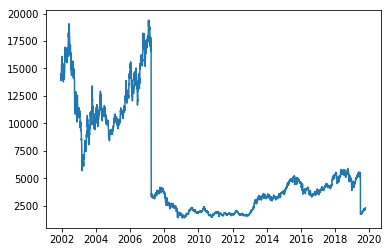

In [17]:
#Close Price not be adjusted
data = data.sort_values('Date')
label = data['Label'].iloc[0]
plt.plot(data['Date'], data['Close'], label="ETF")

In [63]:
#Create windows and normalize the data

window_len = 15

#Create a data point (i.e. a date) which splits the training and testing set
split_date = list(data["Date"][-(2*window_len+1):])[0]

#Split the training and test set
training_set, test_set = data[data['Date'] < split_date], data[data['Date'] >= split_date]
training_set = training_set.drop(['Date','Label','Open','Close','High','Low','Volume'], 1)
test_set = test_set.drop(['Date','Label','Open','Close','High','Low','Volume'], 1)

#Create windows for training
LSTM_training_inputs = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    
    for col in list(temp_set):
        temp_set[col] = temp_set[col]/temp_set[col].iloc[0] - 1

    LSTM_training_inputs.append(temp_set)
LSTM_training_outputs = (training_set['CloseAdjust'][window_len:].values/training_set['CloseAdjust'][:-window_len].values)-1

LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

#Create windows for testing
LSTM_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    
    for col in list(temp_set):
        temp_set[col] = temp_set[col]/temp_set[col].iloc[0] - 1
    
    LSTM_test_inputs.append(temp_set)
LSTM_test_outputs = (test_set['CloseAdjust'][window_len:].values/test_set['CloseAdjust'][:-window_len].values)-1

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

In [64]:
#print(test_set)
print(temp_set[col])
print('/n')
print(temp_set[col].iloc[0])


4350    0.000000
4351    0.013423
4352    0.013423
4353    0.014382
4354    0.036433
4355    0.046500
4356    0.036913
4357    0.031160
4358    0.015340
4359    0.018217
4360    0.023490
4361    0.048418
4362    0.053212
4363    0.079099
4364    0.117929
Name: CloseAdjust, dtype: float64
/n
0.0


In [65]:
#LSTM model definition
def build_model(inputs, output_size, neurons, activ_func="linear", dropout=0.20, loss="mae", optimizer="adam"):
    
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [66]:
#Train the LSTM model

# initialise model architecture
nn_model = build_model(LSTM_training_inputs, output_size=1, neurons = 64)

# train model on data
nn_history = nn_model.fit(LSTM_training_inputs, LSTM_training_outputs, epochs=5, batch_size=1, verbose=2, shuffle=True)

Epoch 1/5
 - 98s - loss: 0.0202
Epoch 2/5
 - 97s - loss: 0.0177
Epoch 3/5
 - 97s - loss: 0.0175
Epoch 4/5
 - 97s - loss: 0.0175
Epoch 5/5
 - 97s - loss: 0.0172


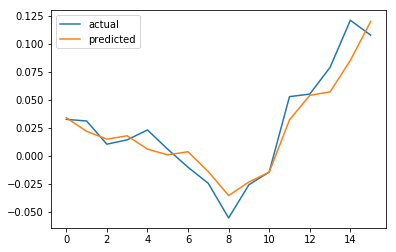

The Mean Absolute Error is: 0.011208554705477741


In [67]:
#Plot of prediction of one data point ahead
#As can be seen in the plot, one step prediction is not bad. The scale is a bit of, because the data is normalized.

plt.plot(LSTM_test_outputs, label = "actual")
plt.plot(nn_model.predict(LSTM_test_inputs), label = "predicted")
plt.legend()
plt.show()
MAE = mean_absolute_error(LSTM_test_outputs, nn_model.predict(LSTM_test_inputs))
print('The Mean Absolute Error is: {}'.format(MAE))

In [68]:
print(LSTM_test_inputs.shape)
print(LSTM_test_inputs)
print(LSTM_test_outputs)

(16, 15, 1)
[[[ 0.        ]
  [ 0.01485149]
  [ 0.03564356]
  [ 0.03267327]
  [ 0.0460396 ]
  [ 0.07425743]
  [ 0.08168317]
  [ 0.09158416]
  [ 0.10990099]
  [ 0.07920792]
  [ 0.07227723]
  [ 0.02821782]
  [ 0.03069307]
  [ 0.03267327]
  [ 0.02970297]]

 [[ 0.        ]
  [ 0.0204878 ]
  [ 0.01756098]
  [ 0.03073171]
  [ 0.05853659]
  [ 0.06585366]
  [ 0.07560976]
  [ 0.09365854]
  [ 0.06341463]
  [ 0.05658537]
  [ 0.01317073]
  [ 0.01560976]
  [ 0.01756098]
  [ 0.01463415]
  [ 0.01756098]]

 [[ 0.        ]
  [-0.00286807]
  [ 0.01003824]
  [ 0.03728489]
  [ 0.04445507]
  [ 0.0540153 ]
  [ 0.07170172]
  [ 0.04206501]
  [ 0.03537285]
  [-0.00717017]
  [-0.00478011]
  [-0.00286807]
  [-0.00573614]
  [-0.00286807]
  [ 0.01051625]]

 [[ 0.        ]
  [ 0.01294343]
  [ 0.04026846]
  [ 0.04745925]
  [ 0.05704698]
  [ 0.07478428]
  [ 0.04506232]
  [ 0.03835091]
  [-0.00431448]
  [-0.00191755]
  [ 0.        ]
  [-0.00287632]
  [ 0.        ]
  [ 0.01342282]
  [ 0.01342282]]

 [[ 0.        ]
  [ 

In [46]:
#Reference1: https://www.kaggle.com/johanvandenheuvel/lstm-model-of-stockdata
#Reference2: https://github.com/llSourcell/How-to-Predict-Stock-Prices-Easily-Demo/blob/master/lstm.py